# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0


   ---------------------------------------- 0/3 [tabulate]
   -------------------------- ------------- 2/3 [sklearn_crfsuite]
   ---------------------------------------- 3/3 [sklearn_crfsuite]



#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [7]:
# define a function to load json file to a dataframe
def load_json_to_dataframe(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [8]:
# read the json file by giving the file path and create a dataframe
df = load_json_to_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [10]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [11]:
# print the dimensions of dataframe - df
print("DataFrame dimensions:", df.shape)

DataFrame dimensions: (285, 2)


In [12]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [17]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
df['input_tokens'] = df['input']
df['pos_tokens'] = df['pos']

# Tokenize input
df['input_tokens'] = df['input_tokens'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos_tokens'].apply(lambda x: x.split())  

In [16]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [18]:
# create input_length and pos_length columns for the input_tokens and pos_tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [19]:
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

In [21]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]

print("Number of rows with unequal input_length and pos_length:", len(unequal_rows))
print("Rows with unequal input_length and pos_length:")
display(unequal_rows)

Number of rows with unequal input_length and pos_length: 5
Rows with unequal input_length and pos_length:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [22]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    labels = set(label for tokens in df['pos_tokens'] for label in tokens)
    print("Unique POS labels in the recipe data:", labels)

unique_labels(df)

Unique POS labels in the recipe data: {'quantity', 'ingredient', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [25]:
# Insights after validation of recipe data

# The validation step checked whether the number of input tokens matches the number of POS labels for each row.
# The following insights were observed:

display(Markdown("""
**Insights after validation:**

- Most rows in the dataframe have matching lengths for `input_tokens` and `pos_tokens`, indicating well-aligned data.
- However, there are **5 rows** (indexes: 17, 27, 79, 164, 207) where the lengths do not match.
- These rows require cleaning and formatting before further processing, as misalignment can cause issues in model training and evaluation.
- It is recommended to drop or correct these rows to ensure data consistency.
"""))


**Insights after validation:**

- Most rows in the dataframe have matching lengths for `input_tokens` and `pos_tokens`, indicating well-aligned data.
- However, there are **5 rows** (indexes: 17, 27, 79, 164, 207) where the lengths do not match.
- These rows require cleaning and formatting before further processing, as misalignment can cause issues in model training and evaluation.
- It is recommended to drop or correct these rows to ensure data consistency.


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [26]:
# drop the irrelevant recipe data
df = df.drop(unequal_rows.index).reset_index(drop=True)

In [29]:
print("DataFrame dimensions after dropping rows with different lenghts for input_tokens and pos_tokes:", df.shape)

DataFrame dimensions after dropping rows with different lenghts for input_tokens and pos_tokes: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [30]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [31]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]

print("Number of rows with unequal input_length and pos_length:", len(unequal_rows))

Number of rows with unequal input_length and pos_length: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [32]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [33]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
0                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1  200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredi

In [34]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
0                                                                                                                                                                                                                                                                                      1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
1  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [35]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))

Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


In [36]:
# validate the shape of training and validation samples
print("Training samples shape:", train_df.shape)
print("Validation samples shape:", val_df.shape)

Training samples shape: (196, 6)
Validation samples shape: (84, 6)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [37]:
# Display the number of unique labels present in y_train
y_train_unique_labels = set(label for seq in y_train for label in seq)
print("Number of unique labels in y_train:", len(y_train_unique_labels))
print("Unique labels in y_train:", y_train_unique_labels)

Number of unique labels in y_train: 3
Unique labels in y_train: {'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [38]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [39]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [40]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    # Extract input and pos tokens
    input_tokens = df['input_tokens'].tolist()
    pos_tokens = df['pos_tokens'].tolist()

    # Flatten the lists
    flat_input_tokens = flatten_list(input_tokens)
    flat_pos_tokens = flatten_list(pos_tokens)

    # Validate lengths
    if len(flat_input_tokens) != len(flat_pos_tokens):
        print(f"Error: Length mismatch in {dataset_name} data.")
        return None, None

    # Display first 10 records
    print(f"First 10 records of {dataset_name} data:")
    for i in range(10):
        print(f"Input: {flat_input_tokens[i]}, POS: {flat_pos_tokens[i]}")

    return flat_input_tokens, flat_pos_tokens

In [41]:
# extract the tokens and its pos tags
flat_input_tokens, flat_pos_tokens = extract_and_validate_tokens(train_df, dataset_name)

First 10 records of Training data:
Input: 250, POS: quantity
Input: grams, POS: unit
Input: Okra, POS: ingredient
Input: Oil, POS: ingredient
Input: 1, POS: quantity
Input: Onion, POS: ingredient
Input: finely, POS: ingredient
Input: chopped, POS: ingredient
Input: Tomato, POS: ingredient
Input: Grated, POS: ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [42]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    ingredient = []
    unit = []
    quantity = []

    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredient.append(token)
        elif pos == 'unit':
            unit.append(token)
        elif pos == 'quantity':
            quantity.append(token)

    # Validate the lists
    if not all(label in ['ingredient', 'unit', 'quantity'] for label in pos_tags):
        print("Error: Invalid POS tags found.")
        return [], [], []

    return ingredient, unit, quantity

In [44]:
#  call the function to categorise the labels into respective list
ingredient_list, unit_list, quantity_list = categorize_tokens(flat_input_tokens, flat_pos_tokens)

In [49]:
print(f"Ingrediant List: {ingredient_list[:10]}")
print(f"Unit List: {unit_list[:10]}")
print(f"Quantity List: {quantity_list[:10]}")

Ingrediant List: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Unit List: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Quantity List: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [56]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):
    # Count occurrences of each item
    item_counts = Counter(item_list)

    # Get the most common items
    top_items = item_counts.most_common(10)

    # Display the top items
    print(f"Top 10 {pos_label} in {dataset_name}:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items



In [57]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredient_list, "ingredients", dataset_name)

Top 10 ingredients in Training:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [58]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(unit_list, "units", dataset_name)

Top 10 units in Training:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [60]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, pos_label, dataset_name):
    items, counts = zip(*top_items)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(items), y=list(counts), palette="viridis")
    plt.title(f"Top 10 {pos_label.capitalize()} in {dataset_name} Data")
    plt.xlabel(pos_label.capitalize())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



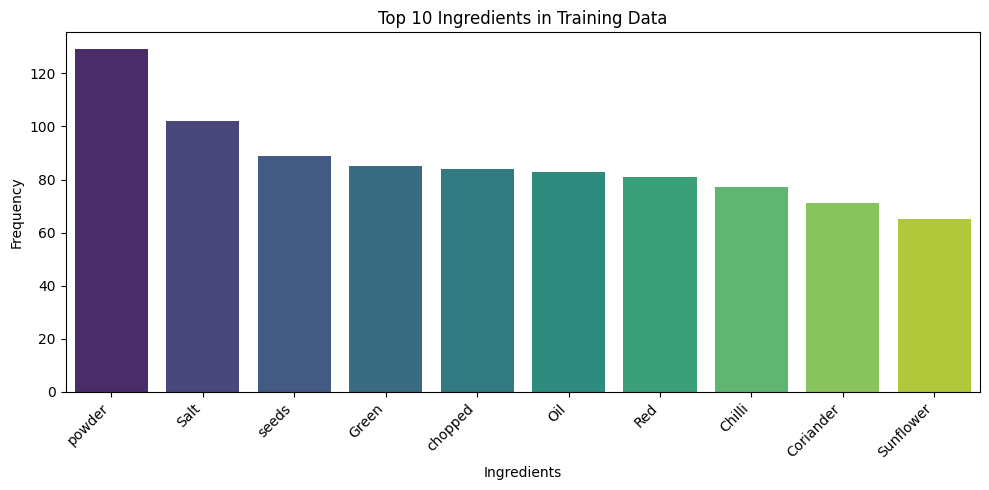

In [63]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "ingredients", dataset_name)

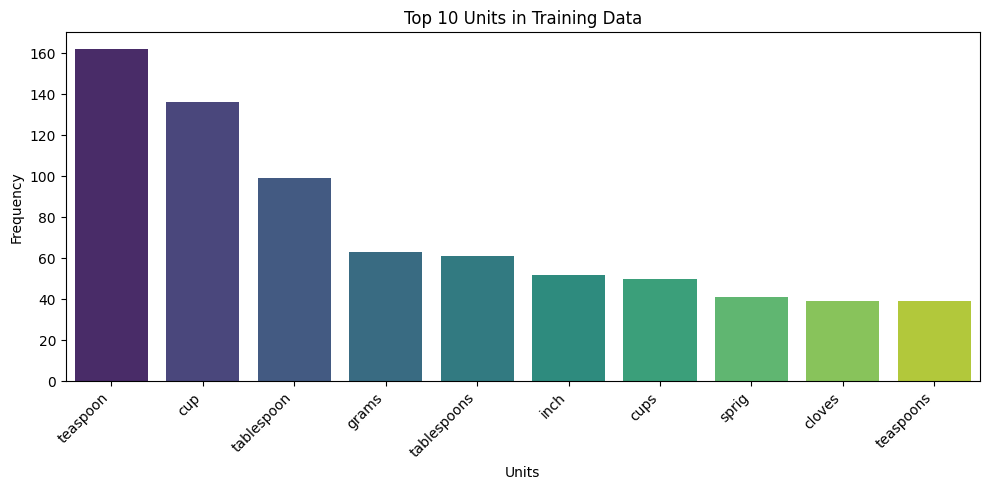

In [64]:
# plot the top frequent units in training data
plot_top_items(top_units, "units", dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [ ]:
# define unit and quantity keywords along with quantity pattern
# Define unit keywords (common measurement units in recipes)
unit_keywords = {
    'cup', 'cups', 'teaspoon', 'teaspoons', 'tsp', 'tablespoon', 'tablespoons', 'tbsp',
    'gram', 'grams', 'gms', 'kg', 'kilogram', 'kilograms', 'mililiter', 'mililiters', 'ml', 'liter', 'liters', 'l',
    'oz', 'ounce', 'ounces', 'pound', 'pounds', 'lb', 'lbs', 'pinch', 'pinches', 'clove', 'cloves',
    'sprig', 'sprigs', 'slice', 'slices', 'piece', 'pieces', 'stick', 'sticks', 'inch', 'inches',
    'packet', 'packets', 'can', 'cans', 'drop', 'drops', 'dash', 'dashes', 'bunch', 'bunches',
    'scoop', 'scoops', 'quart', 'quarts', 'pint', 'pints', 'dl', 'dl.', 'g', 'mg', 'milligram', 'milligrams',
    'tablespoonful', 'tablespoonfuls', 'teaspoonful', 'teaspoonfuls', 'strip', 'strips'
}


# Define quantity keywords (words representing fractions or descriptive quantities)
quantity_keywords = {
    'half', 'quarter', 'third', 'fourth', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
    'eight', 'nine', 'ten', 'eleven', 'twelve', 'dozen', 'few', 'several', 'some', 'single', 'double',
    'triple', 'couple', 'pair', '1/2', '1/4', '3/4', '1/3', '2/3', '1-1/2', '1-1/4', '1-3/4', '1-2/3',
    '1-1/3', '3-4', '1-2', '2-1/2', '3-1/2', '1/8', '2/5', '3/5', '4/5', '5/8', '7/8', '100', '200', '250',
    '500', '750'
}

# Regex pattern to match quantities: integers, decimals, fractions, and mixed numbers
quantity_pattern = re.compile(r'^(\d+([.,]\d+)?|\d+/\d+|\d+-\d+/\d+)$')

In [67]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [68]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):
    """
    Extract features for the i-th token in the sentence.
    sent: list of tokens (strings)
    i: index of the token
    Returns: dict of features
    """
    # Process the entire sentence with spaCy
    doc = nlp(" ".join(sent))
    token = doc[i]
    features = {}

    # --- Core Features ---
    features['bias'] = 1.0
    features['token'] = token.text.lower()
    features['lemma'] = token.lemma_.lower()
    features['pos_tag'] = token.pos_
    features['tag'] = token.tag_
    features['dep'] = token.dep_
    features['shape'] = token.shape_
    features['is_stop'] = token.is_stop
    features['is_digit'] = token.is_digit
    features['has_digit'] = any(char.isdigit() for char in token.text)
    features['has_alpha'] = any(char.isalpha() for char in token.text)
    features['hyphenated'] = '-' in token.text
    features['slash_present'] = '/' in token.text
    features['is_title'] = token.is_title
    features['is_upper'] = token.is_upper
    features['is_punct'] = token.is_punct

    # --- Improved Quantity & Unit Detection ---
    tok_lower = token.text.lower()
    features['is_quantity'] = (
        tok_lower in quantity_keywords or
        bool(quantity_pattern.match(tok_lower))
    )
    features['is_unit'] = tok_lower in unit_keywords
    features['is_numeric'] = token.like_num or bool(re.match(r'^\d+(\.\d+)?$', tok_lower))
    features['is_fraction'] = bool(re.match(r'^\d+/\d+$', tok_lower))
    features['is_decimal'] = bool(re.match(r'^\d+\.\d+$', tok_lower))

    # Preceding and following word (raw text)
    features['preceding_word'] = sent[i-1].lower() if i > 0 else ''
    features['following_word'] = sent[i+1].lower() if i < len(sent)-1 else ''

    # --- Contextual Features ---
    # Previous token features
    if i > 0:
        prev_token = doc[i-1]
        prev_tok_lower = prev_token.text.lower()
        features['prev_token'] = prev_tok_lower
        features['prev_is_quantity'] = (
            prev_tok_lower in quantity_keywords or
            bool(quantity_pattern.match(prev_tok_lower))
        )
        features['prev_is_digit'] = prev_token.is_digit
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Next token features
    if i < len(sent) - 1:
        next_token = doc[i+1]
        next_tok_lower = next_token.text.lower()
        features['next_token'] = next_tok_lower
        features['next_is_unit'] = next_tok_lower in unit_keywords
        features['next_is_ingredient'] = (
            next_tok_lower not in unit_keywords and
            next_tok_lower not in quantity_keywords and
            not bool(quantity_pattern.match(next_tok_lower))
        )
    else:
        features['EOS'] = True  # End of Sentence

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [69]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    """
    Generate feature dictionaries for each token in the sentence.
    sent: list of tokens (strings)
    Returns: list of feature dicts (one per token)
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [70]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

In [71]:
X_train_features

[[{'bias': 1.0,
   'token': '250',
   'lemma': '250',
   'pos_tag': 'NUM',
   'tag': 'CD',
   'dep': 'nummod',
   'shape': 'ddd',
   'is_stop': False,
   'is_digit': True,
   'has_digit': True,
   'has_alpha': False,
   'hyphenated': False,
   'slash_present': False,
   'is_title': False,
   'is_upper': False,
   'is_punct': False,
   'is_quantity': True,
   'is_unit': False,
   'is_numeric': True,
   'is_fraction': False,
   'is_decimal': False,
   'preceding_word': '',
   'following_word': 'grams',
   'BOS': True,
   'next_token': 'grams',
   'next_is_unit': True,
   'next_is_ingredient': False},
  {'bias': 1.0,
   'token': 'grams',
   'lemma': 'gram',
   'pos_tag': 'NOUN',
   'tag': 'NNS',
   'dep': 'nsubj',
   'shape': 'xxxx',
   'is_stop': False,
   'is_digit': False,
   'has_digit': False,
   'has_alpha': True,
   'hyphenated': False,
   'slash_present': False,
   'is_title': False,
   'is_upper': False,
   'is_punct': False,
   'is_quantity': False,
   'is_unit': True,
   'is_nu

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [72]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = list(y_train)
y_val_labels = list(y_val)

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [73]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [74]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [75]:
# Flatten labels in y_train
y_train_flat = [label for seq in y_train for label in seq]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [76]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print("Label counts:", label_counts)
print("Total samples:", total_samples)

Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [77]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: total_samples / (len(label_counts) * count) for label, count in label_counts.items()}
print("Class weights (inverse frequency):", weight_dict)

Class weights (inverse frequency): {'quantity': 2.419727891156463, 'unit': 2.923962186600904, 'ingredient': 0.44548813325818776}


In [78]:
# penalise ingredient label
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 0.5

print("Updated class weights after penalising 'ingredient':", weight_dict)

Updated class weights after penalising 'ingredient': {'quantity': 2.419727891156463, 'unit': 2.923962186600904, 'ingredient': 0.22274406662909388}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [79]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Attach class weights to each token's feature dict for CRF training.
    X: list of list of feature dicts (features for each token in each sentence)
    y: list of list of labels (labels for each token in each sentence)
    weight_dict: dict mapping label to class weight
    Returns: list of list of feature dicts with 'class_weight' key added
    """
    weighted_features = []
    for sent_feats, sent_labels in zip(X, y):
        sent_weighted = []
        for feat, label in zip(sent_feats, sent_labels):
            feat_copy = feat.copy()
            feat_copy['class_weight'] = weight_dict.get(label, 1.0)
            sent_weighted.append(feat_copy)
        weighted_features.append(sent_weighted)
    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [80]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [81]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [84]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_features)


In [83]:
# specify the flat classification report by using training data for evaluation
print("Training Classification Report:")
print(flat_classification_report(y_train_labels, y_pred_train))

Training Classification Report:
              precision    recall  f1-score   support

  ingredient       0.97      0.98      0.97      5323
    quantity       0.94      0.91      0.92       980
        unit       0.92      0.88      0.90       811

    accuracy                           0.96      7114
   macro avg       0.94      0.92      0.93      7114
weighted avg       0.96      0.96      0.96      7114



In [85]:
# create a confusion matrix on training datset
labels = list(weight_dict.keys())
y_true_flat = [label for seq in y_train_labels for label in seq]
y_pred_flat = [label for seq in y_pred_train for label in seq]
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
print("Training Confusion Matrix:")
print(pd.DataFrame(cm, index=labels, columns=labels))

Training Confusion Matrix:
            quantity  unit  ingredient
quantity         887     9          84
unit               7   717          87
ingredient        49    51        5223


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [87]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, "crf_model.pkl")

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [88]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val_features)

In [89]:
# specify flat classification report
print(flat_classification_report(y_val_labels, y_pred_val))

              precision    recall  f1-score   support

  ingredient       0.95      0.97      0.96      2107
    quantity       0.92      0.88      0.90       411
        unit       0.87      0.80      0.84       358

    accuracy                           0.93      2876
   macro avg       0.91      0.88      0.90      2876
weighted avg       0.93      0.93      0.93      2876



In [90]:
# create a confusion matrix on validation dataset
labels = list(weight_dict.keys())
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_pred_val for label in seq]
cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
print("Validation Confusion Matrix:")
print(pd.DataFrame(cm_val, index=labels, columns=labels))

Validation Confusion Matrix:
            quantity  unit  ingredient
quantity         360     3          48
unit               2   287          69
ingredient        30    39        2038


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [91]:
# flatten Labels and Initialise Error Data
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_pred_val for label in seq]
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [92]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
for sent_idx, (tokens, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    for i, (token, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if true_label != pred_label:
            prev_token = tokens[i-1] if i > 0 else ""
            next_token = tokens[i+1] if i < len(tokens)-1 else ""
            context = " ".join(tokens[max(0, i-2):i+3])
            error_data.append({
                "sentence_index": sent_idx,
                "token_index": i,
                "token": token,
                "prev_token": prev_token,
                "next_token": next_token,
                "true_label": true_label,
                "pred_label": pred_label,
                "context": context,
                "class_weight": weight_dict.get(true_label, 1.0)
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [93]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
accuracy = np.mean([t == p for t, p in zip(y_val_true_flat, y_val_pred_flat)])
print(f"Overall Validation Accuracy: {accuracy:.4f}")
display(error_df.head())

Overall Validation Accuracy: 0.9336


sentence_index  token_index     token prev_token next_token  true_label  pred_label                          context  class_weight
0               2           17  teaspoon        Til        Red        unit  ingredient    seeds Til teaspoon Red powder      2.923962
1               2           19    powder        Red      Cumin  ingredient        unit  teaspoon Red powder Cumin Jeera      0.222744
2               2           25       1/2     Dhania      Garam    quantity  ingredient   Powder Dhania 1/2 Garam masala      2.419728
3               2           27    masala      Garam          2  ingredient    quantity         1/2 Garam masala 2 Sweet      0.222744
4               2           28         2     masala      Sweet    quantity  ingredient     Garam masala 2 Sweet Chutney      2.419728

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [94]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
from collections import defaultdict
label_stats = defaultdict(lambda: {"correct": 0, "total": 0})

for true, pred in zip(y_val_true_flat, y_val_pred_flat):
    label_stats[true]["total"] += 1
    if true == pred:
        label_stats[true]["correct"] += 1

# Now calculate accuracy per label
label_accuracy = {
    label: stats["correct"] / stats["total"] 
    for label, stats in label_stats.items()
}

classes = np.unique(y_val_true_flat)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_val_true_flat
)
label_weights = dict(zip(classes, class_weights))

print("Label-wise Accuracy and Class Weights:\n")
for label in classes:
    print(f"{label}: Accuracy = {label_accuracy.get(label, 0):.4f}, "
          f"Weight = {label_weights.get(label, 0):.4f}")

Label-wise Accuracy and Class Weights:

ingredient: Accuracy = 0.9673, Weight = 0.4550
quantity: Accuracy = 0.8759, Weight = 2.3325
unit: Accuracy = 0.8017, Weight = 2.6778


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

In [ ]:
# 1. ingredient
# Accuracy: 96.73% | Weight: 0.4550 (i.e., this class is very frequent in the dataset)
# Most frequent class. High accuracy shows the model handles it well.
# Model is performing very well on the most frequent class, likely because it has enough examples to learn from.

# 2. quantity
# Accuracy: 87.59% | Weight: 2.3325
# This class is underrepresented, hence a higher weight.
# Less frequent but still performs decently. Can improve with more varied examples.

# 3. unit
# Accuracy: 80.17% | Weight: 2.6778
# This class is underrepresented, hence a higher weight.
# Least accurate and underrepresented. 
# Model struggles to distinguish unit tokens from ingredient or quantity, especially when the context is ambiguous (e.g., "cup" vs "cups of flour")
# Needs more data with unit variations ("tablespoon", "tsp", "ml", "g", etc.) and possibly feature engineering.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.